# Libraries

In [ ]:
!python -V # --version

Python 3.12.1


In [125]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

import pickle # To be able to save the model

# Data

Use the following commands to download the data locally: 
- `mkdir /workspaces/mlops-zoomcamp-2025/01-intro/data`
  
- `cd 01-intro/data`
  
- `wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet` - download data for January, 2021

- `wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet` - download data for February, 2021

In [71]:
%%time 

path_to_data = './data/green_tripdata_2021-01.parquet'
df = pd.read_parquet(path_to_data)

CPU times: user 30 ms, sys: 884 μs, total: 30.9 ms
Wall time: 22 ms


In [72]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[us]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[us]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

In [ ]:
# Calculate target variable: trip duration
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']

# Convert duration to minutes
df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)

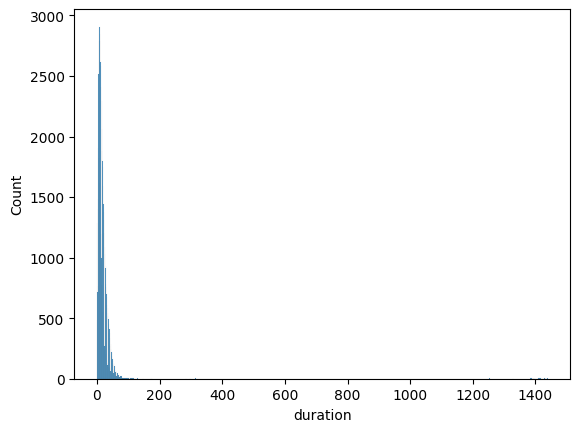

In [77]:
# Look at distribution of trip duration
# sns.displot(df['duration']);
sns.histplot(df['duration']);

In [78]:
# Descriptive statistics of trip duration

percentiles = [0.95, 0.98, 0.99]
df['duration'].describe(percentiles=percentiles).round(2)

count    76518.00
mean        19.93
std         59.34
min          0.00
50%         13.88
95%         44.00
98%         56.00
99%         67.16
max       1439.60
Name: duration, dtype: float64

In [79]:
# Check percentage of data within 1 and 60 minute durations
trip_duration_1_to_60_condition = (df['duration'] >= 1) & (df['duration'] <= 60)

(trip_duration_1_to_60_condition).mean()

np.float64(0.9658903787344154)

In [80]:
# Filter the data to only include trips with duration between 1 and 60 minutes

df = df.loc[trip_duration_1_to_60_condition]

# Feature Engineering

In [81]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [82]:
# Currently, the categorical columns are of type int64
# Convert them to type category
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [ ]:
# Use one-hot encoding to convert categorical columns to numerical
# One-hot encoding converts strings into categorical variables. Convert int64 to string first

df[categorical] = df[categorical].astype(str)

In [84]:
# Converted to object type 
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [85]:
# Turn features (categorical and numerical) into a dictionary 
# to then use them in DictVectorizer

df[categorical + numerical].iloc[:10]

,PULocationID,DOLocationID,trip_distance
0,43,151,1.01
1,166,239,2.53
2,41,42,1.12
3,168,75,1.99
7,75,75,0.45
9,225,265,12.19
10,244,244,3.39
11,75,213,6.69
12,74,238,2.34
13,74,60,5.48


In [86]:
df[categorical + numerical].iloc[:10].to_dict(orient='records')

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48}]

In [87]:
%%time 

train_dicts = df[categorical + numerical].to_dict(orient='records')

CPU times: user 128 ms, sys: 5.87 ms, total: 133 ms
Wall time: 152 ms


In [88]:
%%time

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

CPU times: user 169 ms, sys: 1.88 ms, total: 171 ms
Wall time: 183 ms


In [89]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [90]:
# Target variable

target = 'duration'
y_train = df[target].values

In [91]:
y_train[:10]

array([ 3.93333333,  8.75      ,  5.96666667,  7.08333333,  2.31666667,
       34.03333333, 23.88333333, 13.1       ,  9.51666667, 15.46666667])

# Linear Regression

In [92]:
%%time 

lr = LinearRegression()
lr.fit(X_train, y_train)

CPU times: user 46.1 ms, sys: 0 ns, total: 46.1 ms
Wall time: 29.9 ms


LinearRegression()

In [93]:
# Make predictions
y_pred = lr.predict(X_train)

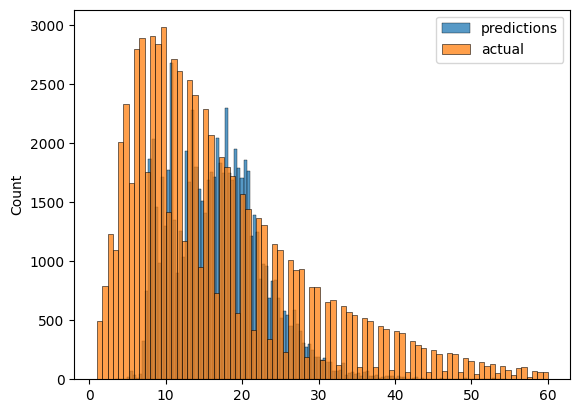

In [94]:
# Visualise the data
sns.histplot(y_pred, label='predictions')
sns.histplot(y_train, label='actual')

plt.legend()


In [ ]:
# Evaluate the performance of the model: use RMSE 
root_mean_squared_error(y_train, y_pred)

# On average, the model is off by 9.84 minutes

9.838799799829626

# Function to pre-process the data

In [100]:
def read_dataframe(filename):
    # Read in the data
    df = pd.read_parquet(filename)

    # Calculate target variable: trip duration
    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']

    # Convert duration to minutes
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)

    # Check percentage of data within 1 and 60 minute durations
    trip_duration_1_to_60_condition = (df['duration'] >= 1) & (df['duration'] <= 60)
    df = df.loc[trip_duration_1_to_60_condition]

    # Feature engineering
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [104]:
%%time 

df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

CPU times: user 687 ms, sys: 14.8 ms, total: 701 ms
Wall time: 690 ms


In [105]:
# Check the size of dataframes
len(df_train), len(df_val)

(73908, 61921)

In [108]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts) # Notice, that we only transform the validation set, not fitting required

In [109]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [110]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

10.499110710357629

# LASSO Regression

In [112]:
# Default parameters of Lasso
lr = Lasso()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

12.212583224318818

In [113]:
# Change default parameters of Lasso
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

10.481255832596219

# Ridge Regression

In [115]:
lr = Ridge()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

10.478171095224786

# More Feature Engineering

In [117]:
# New feature
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [118]:
df_train.head(2)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333,43_151
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000,166_239


In [119]:
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts) # Notice, that we only transform the validation set, not fitting required

In [120]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [126]:
# Linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715208009878

In [ ]:
# Default parameters of Ridge
lr = Ridge()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.70373515548786

In [124]:
# Default parameters of Lasso
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

9.233436225720547

# Saving the Model

In [127]:
%%time 

# Save the dictionary vectoriser and selected model
# mode wb - write binary
with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

CPU times: user 7.09 ms, sys: 0 ns, total: 7.09 ms
Wall time: 15.2 ms
